<a href="https://colab.research.google.com/github/Giofabro/deep-learning/blob/main/Classificatore_immagini_binario_DogsOrCats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2


2025-02-20 11:52:42.338803: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 11:52:42.341401: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 11:52:42.423520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 11:52:42.423629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 11:52:42.424761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [ ]:
# Scarica e decomprime automaticamente il dataset
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", dataset_url, extract=True)

# Percorso alla cartella estratta
base_dir = os.path.join(os.path.dirname(dataset_path), "cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
# Definiamo alcuni parametri chiave
batch_size = 32
img_height = 224
img_width = 224

# Creazione del dataset di training
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

# Creazione del dataset di validazione
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

# Controlliamo le classi disponibili
class_names = train_dataset.class_names
print("Classi:", class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Classi: ['cats', 'dogs']


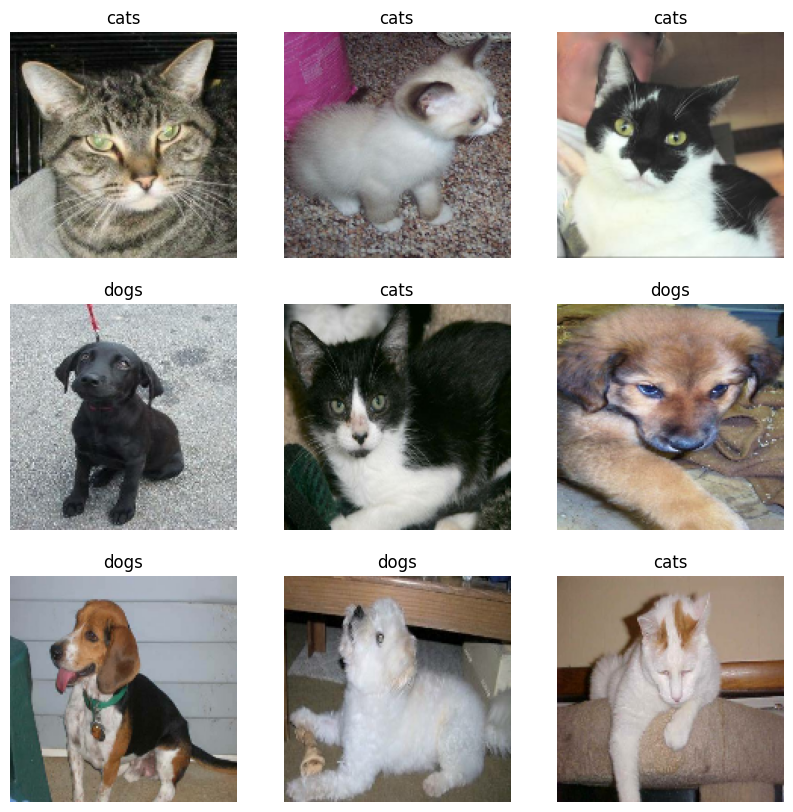

In [ ]:
# Otteniamo un batch di immagini dal dataset di training
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Prende un batch dal dataset
    for i in range(9):  # Mostra 9 immagini
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Converte il tensore in immagine
        plt.title(class_names[labels[i]])  # Mostra il nome della classe (Cat o Dog)
        plt.axis("off")  # Nasconde gli assi
plt.show()

### Data augmentation + normalizzazione

Aggiungiamo varieta ai nostri dati in modo che il modello impari meglio. innanzitutto, riscaliamo a un pixel.

In [ ]:
# Importiamo AUTOTUNE per ottimizzare il caricamento**
AUTOTUNE = tf.data.AUTOTUNE

# Creiamo un livello di Data Augmentation per il Training Set**
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Flip orizzontale
    tf.keras.layers.RandomRotation(0.2),      # Rotazione casuale fino al 20%
    tf.keras.layers.RandomZoom(0.2)           # Zoom casuale fino al 20%
])

# Creiamo un livello di Normalizzazione per tutti i dataset**
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# **Applichiamo Data Augmentation + Normalizzazione SOLO al Training Set**
train_dataset = train_dataset.map(lambda x, y: (data_aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# **Applichiamo SOLO Normalizzazione a Validation Set**
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# **Prefetching per ottimizzare il caricamento dei dati**
train_dataset = train_dataset.prefetch(AUTOTUNE)
validation_dataset = validation_dataset.prefetch(AUTOTUNE)


### Transfer learning

In [ ]:
# modello pre-addestrato (senza il classificatore finale)
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')  # Usiamo i pesi pre-addestrati su ImageNet

# Congeliamo i pesi del modello pre-addestrato per mantenere le feature apprese
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


### Costruzione del modello convoluzionale - Rete CNN

In [ ]:
model = tf.keras.Sequential([

   # Modello pre-addestrato come feature extractor
    base_model,

    # Global average pooling to reduce spatial dimensions before custom layers
    tf.keras.layers.GlobalAveragePooling2D(),

    # Livello fully connected con ReLU
    tf.keras.layers.Dense(512, activation='relu'),

    # Dropout per ridurre l'overfitting
    tf.keras.layers.Dropout(0.5),

    # Ultimo livello con Sigmoid per classificazione binaria
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiliamo il modello
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Riepilogo del modello
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2914369 (11.12 MB)
Trainable params: 656

In [ ]:
# Avviamo l'addestramento del modello
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    verbose=2
)


Epoch 1/5
63/63 - 78s - loss: 0.2435 - accuracy: 0.9090 - val_loss: 0.0599 - val_accuracy: 0.9780 - 78s/epoch - 1s/step
Epoch 2/5
63/63 - 81s - loss: 0.1932 - accuracy: 0.9300 - val_loss: 0.0539 - val_accuracy: 0.9770 - 81s/epoch - 1s/step
Epoch 3/5
63/63 - 80s - loss: 0.1497 - accuracy: 0.9425 - val_loss: 0.0490 - val_accuracy: 0.9790 - 80s/epoch - 1s/step
Epoch 4/5
63/63 - 92s - loss: 0.1420 - accuracy: 0.9435 - val_loss: 0.0570 - val_accuracy: 0.9820 - 92s/epoch - 1s/step
Epoch 5/5
63/63 - 87s - loss: 0.1210 - accuracy: 0.9520 - val_loss: 0.0464 - val_accuracy: 0.9810 - 87s/epoch - 1s/step


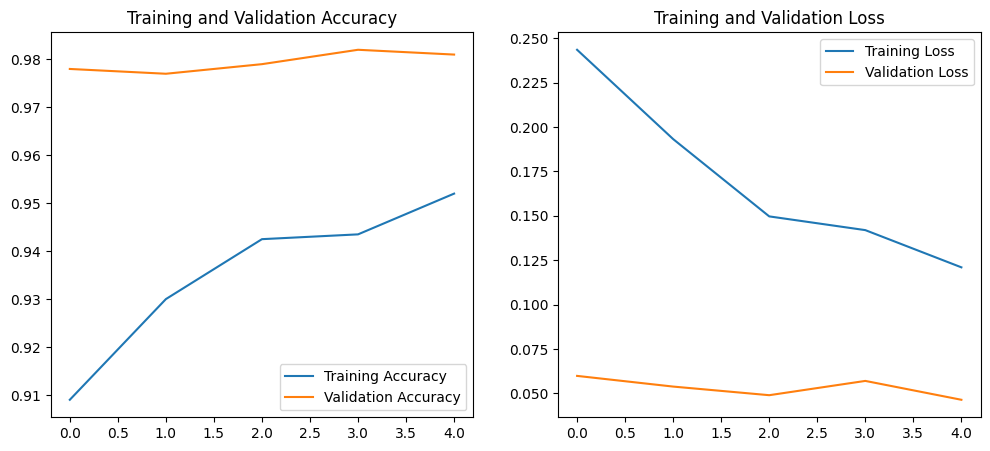

In [ ]:
# Estraiamo i dati dal training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Creiamo i grafici
plt.figure(figsize=(12, 5))

# Grafico dell'accuratezza
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafico della perdita (loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

1/1 [==============================] - 1s 920ms/step
/tmp/ipykernel_40/3718705467.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(predictions[i] > 0.5)  # Se > 0.5 è "Cane", altrimenti "Gatto"


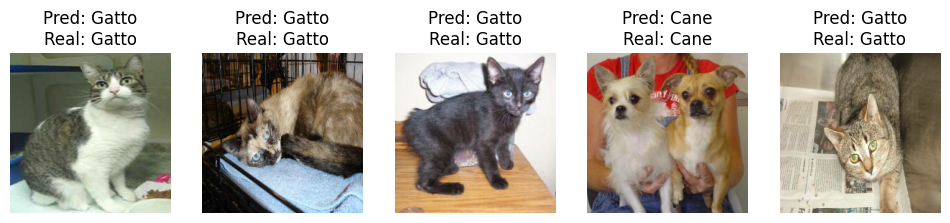

In [ ]:
# Mappa delle etichette (0 = Gatto, 1 = Cane)
class_names = ["Gatto", "Cane"]

# Numero di immagini da mostrare
num_images = 5

# Prendiamo alcune immagini dal validation set
test_images, test_labels = next(iter(validation_dataset.unbatch().batch(num_images)))

# Facciamo la predizione con il modello
predictions = model.predict(test_images)

# Dimensioni delle immagini
plt.figure(figsize=(12, 5))

# Visualizziamo le immagini con la predizione
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)

    # Denormalizziamo l'immagine (portiamo i valori tra 0 e 255, altrimenti si vede tutto nero)
    img = test_images[i].numpy() * 255  # Riporta l'immagine alla scala originale
    img = img.astype("uint8")  # Converte in formato corretto per plt.imshow()

    plt.imshow(img)  # Mostra l'immagine correttamente
    pred_label = int(predictions[i] > 0.5)  # Se > 0.5 è "Cane", altrimenti "Gatto"
    true_label = int(test_labels[i].numpy())  # Etichetta reale
    plt.title(f"Pred: {class_names[pred_label]}\nReal: {class_names[true_label]}")
    plt.axis("off")

plt.show()